In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score

from models.CAE import CAE
from models.VCAE import VCAE
from generate import sin_cos, arma, wind
from train import train
from utils import latent_space, choose_bottleneck

torch.manual_seed(4444)
np.random.seed(4444)

# Create Dataset

In [2]:
n_train = 100
n_valid = 100
n_test = 100
n = n_train+n_valid+n_test

length = 64 # each observation is a vector of size (1,length)

## Generate documents

In [3]:
#X = sin_cos(n, length)
X = arma(n, length)
#X = wind(num_elems=length)

X = torch.from_numpy(X)
print("shape of X:", X.shape)

X_train, X_valid, X_test = X[:n_train], X[n_train:n_train+n_valid], X[n_train+n_valid:n]

shape of X: torch.Size([300, 1, 64])


# Model

In [4]:
M = 4 # number of filters per conv
Lf = 3 # size of the filters
bottleneck_nn = 32
model = CAE(length=length, Lf=Lf, M=M, bottleneck_nn=bottleneck_nn)

## Train

In [5]:
batch_size = 32
train_losses, valid_losses = train(model, X_train, X_valid, iters=3000, batch_size=batch_size, early_stopping_rounds=30)

EPOCH 10 train loss: 4.246610164642334, valid loss: 4.345021367073059
epochs without improvement: 0

EPOCH 20 train loss: 3.4136377573013306, valid loss: 3.6556519865989685
epochs without improvement: 0

EPOCH 30 train loss: 2.8915433287620544, valid loss: 3.158354341983795
epochs without improvement: 0

EPOCH 40 train loss: 2.4913553595542908, valid loss: 2.785103738307953
epochs without improvement: 0

EPOCH 50 train loss: 2.219483196735382, valid loss: 2.488806188106537
epochs without improvement: 0

EPOCH 60 train loss: 1.9743921160697937, valid loss: 2.2482327222824097
epochs without improvement: 0

EPOCH 70 train loss: 1.7655237019062042, valid loss: 2.056584060192108
epochs without improvement: 0

EPOCH 80 train loss: 1.559713989496231, valid loss: 1.8856081366539001
epochs without improvement: 0

EPOCH 90 train loss: 1.4307420551776886, valid loss: 1.7514119744300842
epochs without improvement: 0

EPOCH 100 train loss: 1.3168177604675293, valid loss: 1.6380237638950348
epochs w

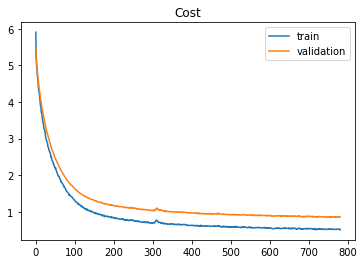

In [6]:
plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

## Load/Save model

In [7]:
#torch.save(model.state_dict(), "../saved_weights/wind64_model")
#model.load_state_dict(torch.load("../saved_weights/wind6_model"))

# Testing

## Average and std correlation

avg and std: 0.8386373626373625 0.04067346877763485

cor: 0.8630036630036628
cor: 0.8743589743589743
cor: 0.8047619047619047
cor: 0.8228937728937729


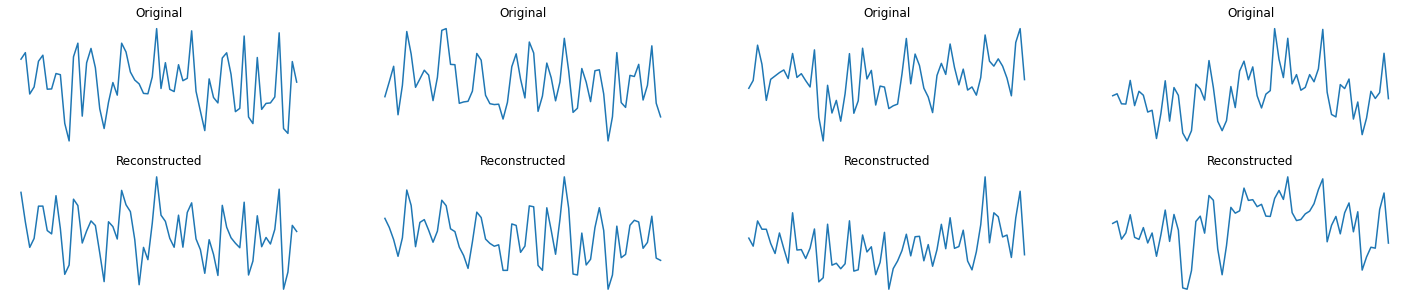

In [8]:
pred = model(X_test).detach().numpy()

# avg and std of cors
cors = [scipy.stats.spearmanr(pred[i,0], X_test[i,0]).correlation for i in range(n_test)]
print("avg and std:", np.mean(cors), np.std(cors))
print()

# plots
n_plots = 4
start = n_plots*0

fig, axs = plt.subplots(nrows=2, ncols=n_plots, figsize=(25,5))
for i in range(n_plots):
    
    axs[0,i].axis("off")
    axs[0,i].set_title("Original")
    axs[0,i].plot(X_test[start+i,0])

    axs[1,i].axis("off")
    axs[1,i].set_title("Reconstructed")
    axs[1,i].plot(pred[start+i,0])
    print("cor:", scipy.stats.spearmanr(pred[start+i,0], X_test[start+i,0]).correlation)

# Latent space

In [9]:
if bottleneck_nn == 2:
    latent_space(model, n=10)

# Choose bootleneck

In [10]:
#vals = choose_bottleneck(X_test, X_train, X_valid, length, M, Lf)
#plt.plot([np.mean(x) for x in vals], "-o", [1]*len(vals))

# Checking important filters

<AxesSubplot:>

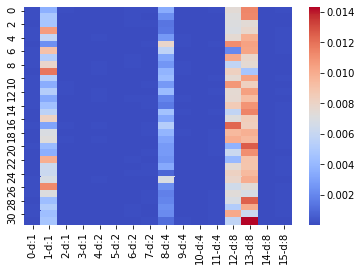

In [11]:
num_filter = 4*M
w_per_filter = length-Lf+1 # weights per filter

num_neurons = bottleneck_nn
if isinstance(model, VCAE):
    num_neurons *= 2

w = np.array([[torch.mean(torch.abs(model.full1.weight[j,i*w_per_filter:(i+1)*w_per_filter])).item() for i in range(num_filter)] for j in range(num_neurons)])

x_axis_labels = [f"{i}-d:{2**(i//M)}" for i in range(w.shape[1])] # number of filter - d:dilatation
sns.heatmap(w, cmap="coolwarm", xticklabels=x_axis_labels) # y-axis => neuron of the bottleneck, x-axis => each position is one filter ordered by dilatation

# Clustering using bootlenecks

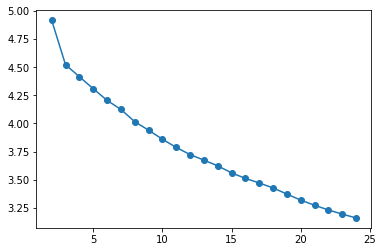

In [12]:
bns = model(X_test, get_bottleneck=True).detach().numpy()
chs = []
for i in range(2,25):
    clustering = AgglomerativeClustering(n_clusters=i)
    clustering.fit(bns) 
    clus = clustering.labels_
    ch = calinski_harabasz_score(bns,clus)
    chs.append(ch)
plt.plot(range(2,len(chs)+2), chs, "o-")

In [13]:
clustering = AgglomerativeClustering(n_clusters=3)
clustering.fit(bns)
clus = clustering.labels_

In [14]:
if bns.shape[1] <= 10: # more than 10 plots is slow
    sns.pairplot(pd.DataFrame(np.c_[bns,clus]), hue=bns.shape[1])

<AxesSubplot:>

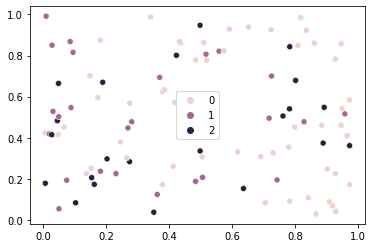

In [15]:
d1, d2 = 0, 1
sns.scatterplot(bns[:,d1], bns[:,d2], hue=clus)